In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch.optim import lr_scheduler
%matplotlib inline

# prepare

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:3000px;  
}

In [4]:
# to GPU or to CPU
device_name = "cuda"

try:
    device = torch.device(device_name)
    torch.randn(1, device = device)
except RuntimeError as err:
    print(f'"{device_name}" is invalid, use CPU instead.')
    device = torch.device("cpu")

In [5]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)# prepare
    plt.imshow(inp)

def plot_model(model, data):
    classes = ("cat", "dog")
    img_tensor, label = data
    input = img_tensor.view(1, 3, 224, 224).to(next(model.parameters()).device)
    target = torch.argmax(model(input), dim = 1).item()
    imshow_tensor(img_tensor)
    plt.title("A {} is predicted as a {}".format(classes[label], classes[target]))

# data

data lives in `data/dogs-vs-cats/data`, refer to [here](data/readme.md) for how I create that folder


In [6]:
path = 'data/dogs-vs-cats/data'

print(f"number of images for training  : {len(glob.glob(os.path.join(path, 'train/*/*.jpg')))}")
print(f"number of images for validation: {len(glob.glob(os.path.join(path, 'test/*/*.jpg')))}")

number of images for training  : 20000
number of images for validation: 5000


In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # we normalize by ImageNet's mean and standard deviation since ResNet model is pretrained on this dataset 
    # If we train from scratch, we can just divide each pixel by 255, `torchvision.transforms.Lambda(lambda x: x/255.0)`
])
train_data = torchvision.datasets.ImageFolder(os.path.join(path, "train"), transform)
valid_data = torchvision.datasets.ImageFolder(os.path.join(path, "test"),  transform)

In [8]:
print(train_data.class_to_idx)
print(train_data.classes) 
print(len(train_data))

{'cat': 0, 'dog': 1}
['cat', 'dog']
20000


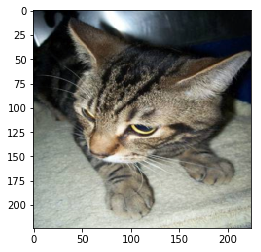

In [9]:
imshow(train_data[50][0])

In [10]:
# MX 150 only has 2G memroy
train_data = torch.utils.data.Subset(train_data, range(200))
valid_data = torch.utils.data.Subset(valid_data, range(50))
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 64)

# model

In [11]:
model = torchvision.models.resnet18(pretrained = True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# train

In [12]:
def train(model, train_loader, epoch, scheduler, logs):
    loss, correct, device = 0, 0, next(model.parameters()).device
    model.train()
    scheduler.step()
    log_batches = np.ceil(np.linspace(0, len(train_loader)-1, logs))
    for batch_i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        batch_loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        batch_correct = torch.sum(torch.argmax(outputs, dim = 1) == targets).item()
        scheduler.optimizer.zero_grad()
        batch_loss.backward()
        scheduler.optimizer.step()
        if batch_i in log_batches: 
            print("Epoch {} [{:5d}-{:5d}/{:5d}], average loss: {:.3f}, correct: {:5d}/{:5d} ({:6.2f}%)".format(epoch+1, len(inputs)*batch_i+1, len(inputs)*(batch_i+1), len(train_loader.dataset), batch_loss.item(), batch_correct, len(targets), batch_correct/len(targets)*100), flush = True)
        loss += batch_loss.item()
        correct += batch_correct
    print("Summary of    Epoch {},       average loss: {:.3f}, correct: {:5d}/{:5d} ({:6.2f}%)".format(epoch+1, loss/len(train_loader), correct, len(train_loader.dataset), correct/len(train_loader.dataset)*100), flush = True)


def valid(model, test_loader, epoch):
    loss, correct, device = 0, 0, next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss += torch.nn.CrossEntropyLoss()(outputs, targets).item()
            correct += torch.sum(torch.argmax(outputs, dim = 1) == targets).item()
    print("Testing after Epoch {},       average loss: {:.3f}, correct: {:5d}/{:5d} ({:6.2f}%)\n".format(epoch+1, loss/len(test_loader), correct, len(test_loader.dataset), correct/len(test_loader.dataset)*100), flush = True)
    return loss, correct

In [13]:
# It's only a toy example, since we only use a small subset of the dataset, the model easily gets over fitted
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

valid(model, valid_loader, 0)
for epoch in range(8):
   train(model, train_loader, epoch, scheduler, 4)
   valid(model, valid_loader, epoch)

Testing after Epoch 1,       average loss: 0.344, correct:    50/   50 (100.00%)

Epoch 1 [    1-   32/  200], average loss: 0.348, correct:    30/   32 ( 93.75%)
Epoch 1 [   65-   96/  200], average loss: 0.218, correct:    32/   32 (100.00%)
Epoch 1 [  129-  160/  200], average loss: 0.074, correct:    32/   32 (100.00%)
Epoch 1 [   49-   56/  200], average loss: 0.024, correct:     8/    8 (100.00%)
Summary of    Epoch 1,       average loss: 0.162, correct:   197/  200 ( 98.50%)
Testing after Epoch 1,       average loss: 0.019, correct:    50/   50 (100.00%)

Epoch 2 [    1-   32/  200], average loss: 0.018, correct:    32/   32 (100.00%)
Epoch 2 [   65-   96/  200], average loss: 0.007, correct:    32/   32 (100.00%)
Epoch 2 [  129-  160/  200], average loss: 0.005, correct:    32/   32 (100.00%)
Epoch 2 [   49-   56/  200], average loss: 0.002, correct:     8/    8 (100.00%)
Summary of    Epoch 2,       average loss: 0.007, correct:   200/  200 (100.00%)
Testing after Epoch 2,    

# other code

In [14]:
# explore residual block interactively
resnet = torchvision.models.resnet34(pretrained = True) 
print('before:')
x = torch.randn(64, 3, 256, 256); print(x.shape)
x = resnet.conv1(x)             ; print(x.shape)
x = resnet.bn1(x)
x = resnet.relu(x)
x = resnet.maxpool(x)           ; print(x.shape)
print('layer1:')
identity = x
x = resnet.layer1[0].conv1(x)   ; print(x.shape)
x = resnet.layer1[0].bn1(x)
x = resnet.layer1[0].relu(x)
x = resnet.layer1[0].conv2(x)   ; print(x.shape)
x = resnet.layer1[0].bn2(x)
x += identity
x = resnet.layer1[0].relu(x)
print(torch.equal(x, resnet.layer1[0](identity)))
x = resnet.layer1[1](x)         ; print(x.shape)
x = resnet.layer1[2](x)         ; print(x.shape)
print('layer2:')
identity = x
x = resnet.layer2[0].conv1(x)   ; print(x.shape)
x = resnet.layer2[0].bn1(x)
x = resnet.layer2[0].relu(x)
x = resnet.layer2[0].conv2(x)   ; print(x.shape)
x = resnet.layer2[0].bn2(x)
print(resnet.layer2[0].downsample[0](identity).shape)
x += resnet.layer2[0].downsample(identity)
x = resnet.layer2[0].relu(x)
print(torch.equal(x, resnet.layer2[0](identity)))

before:
torch.Size([64, 3, 256, 256])
torch.Size([64, 64, 128, 128])
torch.Size([64, 64, 64, 64])
layer1:
torch.Size([64, 64, 64, 64])
torch.Size([64, 64, 64, 64])
True
torch.Size([64, 64, 64, 64])
torch.Size([64, 64, 64, 64])
layer2:
torch.Size([64, 128, 32, 32])
torch.Size([64, 128, 32, 32])
torch.Size([64, 128, 32, 32])
True


In [15]:
# simple network demonstrating how image size change as being convoluted
class Net(torch.nn.Module):
    def __init__(self, n_class, n_pixel):
        super().__init__()
        self.input_n_pixel = n_pixel
        self.conv1 = torch.nn.Conv2d(3, 10, kernel_size = 5)
        n_pixel = (n_pixel - (self.conv1.kernel_size[0] -1))//2   
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size = 6)
        self.conv2_drop = torch.nn.Dropout2d()
        n_pixel = (n_pixel - (self.conv2.kernel_size[0] -1))//2       
        self.fc1 = torch.nn.Linear(n_pixel*n_pixel*20, 500)
        self.fc2 = torch.nn.Linear(500, 50)
        self.fc3 = torch.nn.Linear(50, n_class)

    def forward(self, x):
        F = torch.nn.functional
        x = x.view(-1, 3, self.input_n_pixel, self.input_n_pixel) # support a single image
        x = F.relu(F.max_pool2d(                self.conv1(x),  2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.dropout(F.relu(self.fc1(x)), training = self.training)
        x = F.dropout(F.relu(self.fc2(x)), training = self.training)
        x = self.fc3(x)
        return x